In [206]:
import quantrocket.master
import pandas as pd, numpy as np
import math
from quantrocket import get_prices
from collections import defaultdict
import matplotlib.pyplot as plt

from quantrocket.master import get_securities

In [231]:
get_securities(symbols=['SI', 'ASAN', 'HCM'], sec_types="STK", currencies=["USD"], exclude_delisted=True)

,Symbol,Exchange,Country,Currency,SecType,Etf,Timezone,Name,PriceMagnifier,Multiplier,Delisted,DateDelisted,LastTradeDate,RolloverDate
Sid,,,,,,,,,,,,,,
FIBBG00B6VCGJ1,HCM,XNAS,US,USD,STK,False,America/New_York,HUTCHISON CHINA MEDITECH-ADR,1,1,False,NaT,NaT,NaT
FIBBG00MMM95S7,SI,XNYS,US,USD,STK,False,America/New_York,SILVERGATE CAPITAL CORP-CL A,1,1,False,NaT,NaT,NaT
FIBBG00WYHL732,ASAN,XNYS,US,USD,STK,False,America/New_York,ASANA INC - CL A,1,1,False,NaT,NaT,NaT


In [236]:
target_sids = get_securities(symbols=['SI', 'ASAN', 'HCM'], sec_types="STK", currencies=["USD"], exclude_delisted=True).index.to_list()

In [81]:
df_all = get_prices("usstock-1d", universes="usstock", start_date="2020-01-03", fields=["Close", "Volume"])

In [258]:
target_sids

['FIBBG00B6VCGJ1', 'FIBBG00MMM95S7', 'FIBBG00WYHL732']

In [234]:
size_i_start, size_i_end = -3, -1
tallest_sids = df_all.loc["Close"].mean().sort_values()[size_i_start:size_i_end].index.tolist()

In [237]:
df_prices = df_all[target_sids].fillna(method="ffill")

In [243]:
df_close = df_prices.loc["Close"]
df_volume = df_prices.loc["Volume"]

In [244]:
vv = None
def roll_func(v):
    global vv
    vv = v
    return np.mean(v)

<AxesSubplot:xlabel='Date'>

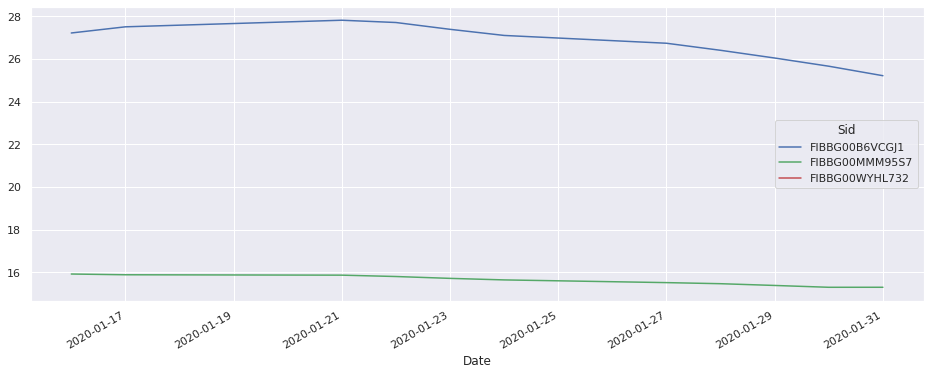

In [245]:
df_close.iloc[:20].rolling(10).apply(roll_func).plot()

<AxesSubplot:xlabel='Date'>

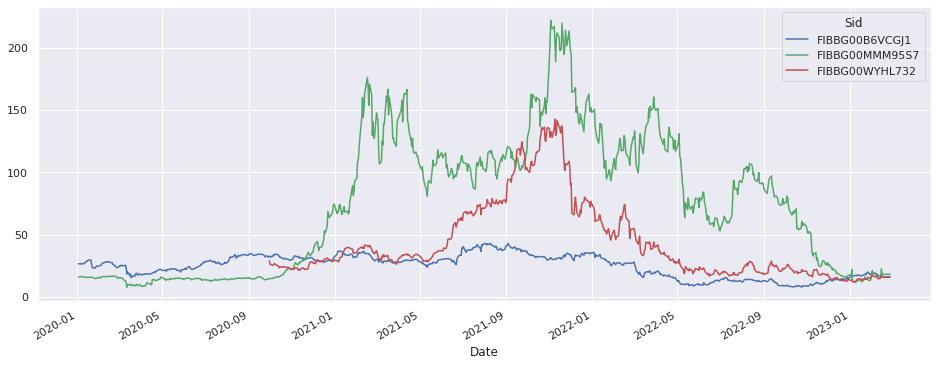

In [248]:
df_close.plot()

<AxesSubplot:xlabel='Date'>

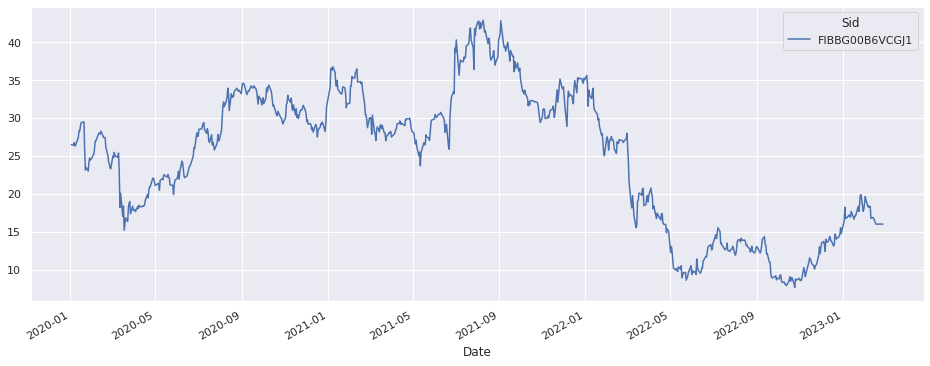

In [295]:
df_close[['FIBBG00B6VCGJ1']].plot()

<AxesSubplot:xlabel='Date'>

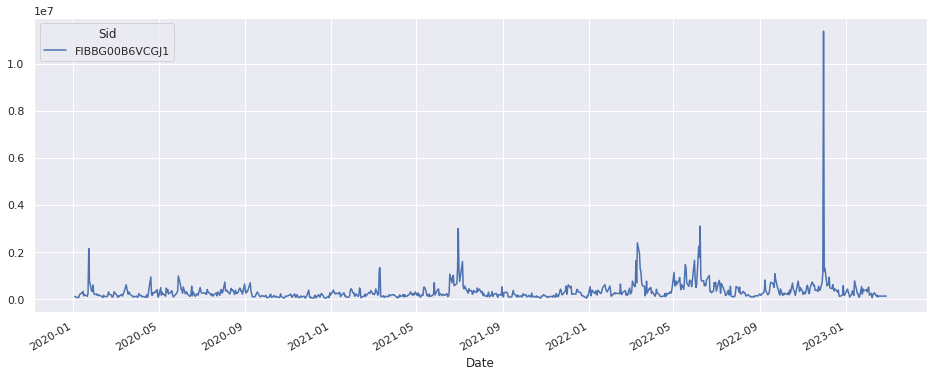

In [297]:
df_volume[['FIBBG00B6VCGJ1']].plot()

<AxesSubplot:xlabel='Date'>

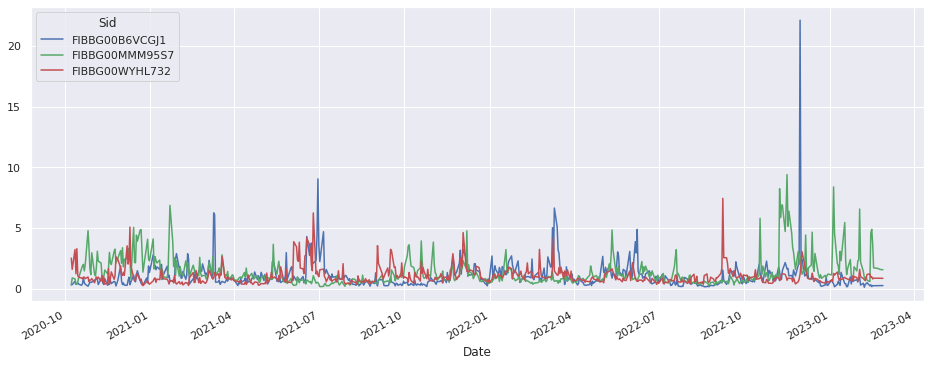

In [304]:
(df_volume / df_volume.rolling(80).mean()).iloc[-600:].plot()

<AxesSubplot:xlabel='Date'>

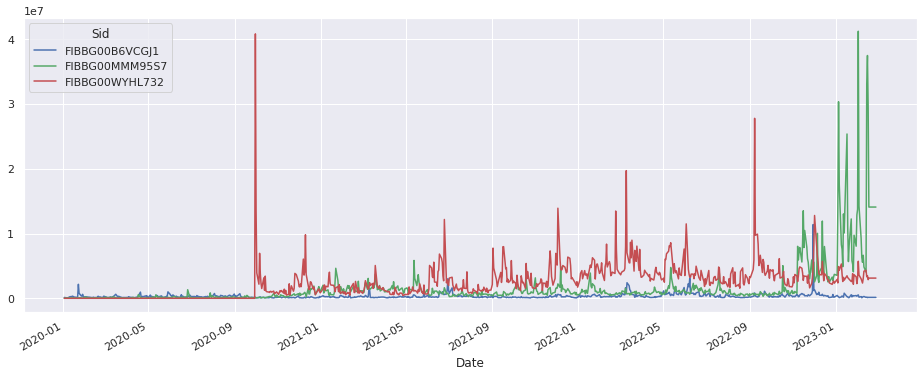

In [298]:
df_volume.plot()

<AxesSubplot:xlabel='Date'>

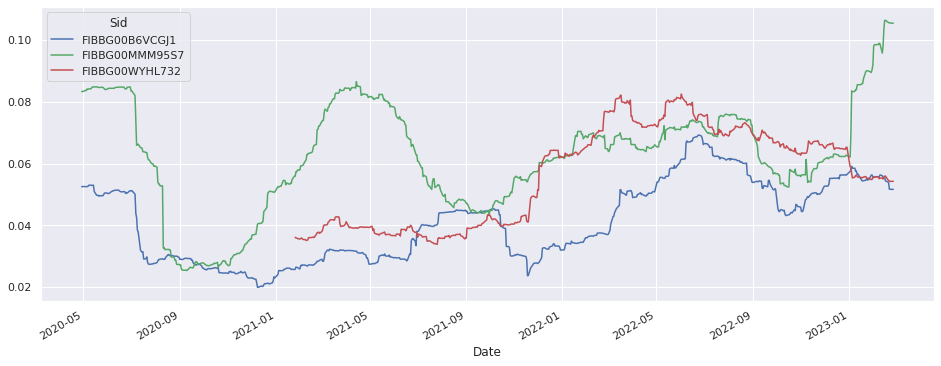

In [269]:
df_close.pct_change().rolling(80).std().plot()

<AxesSubplot:xlabel='Date'>

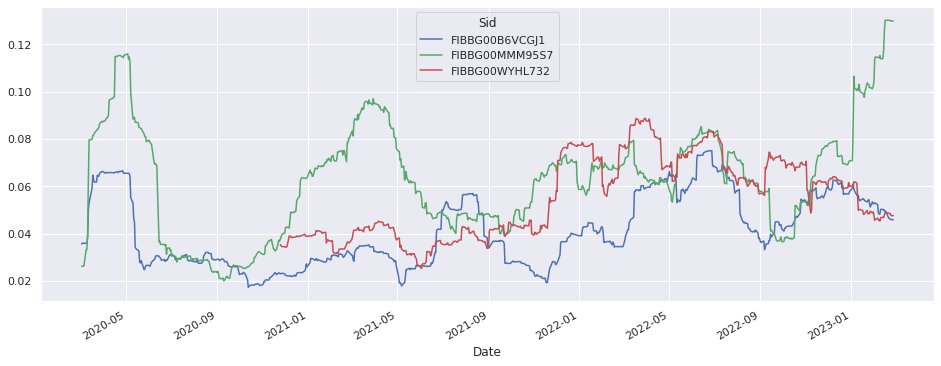

In [293]:
df_close.pct_change().rolling(40).std().plot()

In [249]:
rows = vv
rows

Date
2020-01-17    15.58
2020-01-21    15.76
2020-01-22    15.65
2020-01-23    15.56
2020-01-24    15.36
2020-01-27    14.61
2020-01-28    14.86
2020-01-29    14.89
2020-01-30    14.89
2020-01-31    15.78
dtype: float64

In [250]:
def get_min_drop_and_recovery(rows):
    maxPrice = None
    minDrop = None
    minDropPrice = None
    maxPriceEpochSeconds = 0

    for r in rows.iteritems():
        bwtClose = r[1];
        if maxPrice is None or bwtClose > maxPrice:
            maxPrice = bwtClose
            maxPriceEpochSeconds = r[0]

        drop = (bwtClose - maxPrice) / maxPrice
        if minDrop is None or drop < minDrop:
            minDrop = drop
            minDropPrice = bwtClose

    recovery = (bwtClose - minDropPrice) / minDropPrice
    return minDrop, recovery

def get_max_jump_and_recovery(rows):
    minPrice = None
    maxJump = None
    maxJumpPrice = None
    minPriceEpochSeconds = 0

    for r in rows.iteritems():
        bwtClose = r[1];
        if minPrice is None or bwtClose < minPrice:
            minPrice = bwtClose
            minPriceEpochSeconds = r[0]

        jump = (bwtClose - minPrice) / minPrice;
        if maxJump is None or jump > maxJump:
            maxJump = jump
            maxJumpPrice = bwtClose

    recovery = (bwtClose - maxJumpPrice) / maxJumpPrice
    return maxJump, recovery

In [251]:
def get_max_jump(rows):
    return get_max_jump_and_recovery(rows)[0]

def get_recovery_after_max_jump(rows):
    return get_max_jump_and_recovery(rows)[1]

def get_min_drop(rows):
    return get_min_drop_and_recovery(rows)[0]

def get_recovery_after_min_drop(rows):
    return get_min_drop_and_recovery(rows)[1]

In [252]:
def get_smoothed_change(rows, smooth_window):
    rows = rows.rolling(smooth_window).apply(np.mean).dropna()
    l = len(rows)
    mean_left = rows[:l].mean()
    #print(rows)
    return (rows[-1] - mean_left) / mean_left

In [253]:
df_close.pct_change().std()

Sid
FIBBG00B6VCGJ1    0.043530
FIBBG00MMM95S7    0.068273
FIBBG00WYHL732    0.056559
dtype: float64

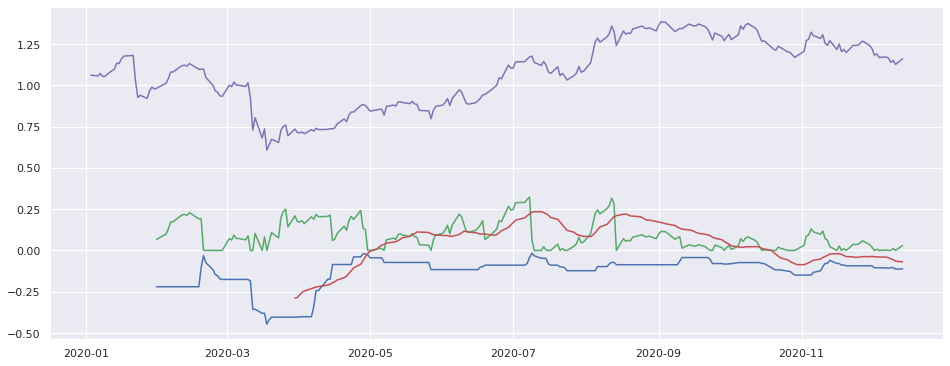

In [262]:
window_size = 20
plt.plot(df_close[['FIBBG00B6VCGJ1']].rolling(window_size).apply(get_min_drop).iloc[:240])
plt.plot(df_close[['FIBBG00B6VCGJ1']].rolling(window_size).apply(get_recovery_after_min_drop).iloc[:240])
plt.plot(df_close[['FIBBG00B6VCGJ1']].rolling(60).apply(get_smoothed_change, args=(10,)).iloc[:240])
plt.plot((df_close[['FIBBG00B6VCGJ1']].iloc[:240] - 0.0) / 25.)
plt.show()  # doctest: +SKIP

## signal

In [ ]:
def get_df_ema(df, move_window_size):
    df.rolling(move_window_size).apply(get_min_drop)
    df.rolling(move_window_size).apply(get_recovery_after_min_drop)
    df.rolling(60).apply(get_smoothed_change, args=(10,))


## price to signal

In [ ]:
def prices_to_signals(prices, param):
    """
    This method receives a DataFrame of prices and should return a
    DataFrame of integer signals, where 1=long, -1=short, and 0=cash.
    """
    df_close = prices.loc["Close"]
    df_ama, df_h, df_l = get_df_ama(df_close, params["ALPHA_MIN"], params["ALPHA_MAX"], params["BETA"], params["GAMMA"])

    longs = (df_close >= df_h)
    shorts = (df_close <= df_l)

    #shorts = (df_close >= df_h)
    #longs = (df_close <= df_l)

    longs = longs.astype(int)
    shorts = -shorts.astype(int)

    # Combine long and short signals
    signals = -shorts
    #signals = longs.where(longs == 1, shorts)

    # Resample using the rebalancing interval.
    # Keep only the last signal of the month, then fill it forward
    signals = signals.resample(params["REBALANCE_INTERVAL"]).last()
    signals = signals.reindex(df_close.index, method="ffill")

    return signals

## signals_to_target_weights

In [309]:
def signals_to_target_weights(signals, prices):
    """
    This method receives a DataFrame of integer signals (-1, 0, 1) and
    should return a DataFrame indicating how much capital to allocate to
    the signals, expressed as a percentage of the total capital allocated
    to the strategy (for example, -0.25, 0, 0.1 to indicate 25% short,
    cash, 10% long).
    """
    num_signals = df_signals.abs().sum(axis=1)
    expected_signals = (size_i_end - size_i_start) / 3.0

    # total positions proportional to signals. a signal always assigned constant weight
    # total weights sums 1
    # the constant controlls the cagr but drawdown is multiplied.
    weights = df_signals.div(num_signals, axis=0)

    # a signal assigned bonus if there are many signals
    #weights = df_signals.div(num_signals, axis=0).mul((np.log2(num_signals/expected_signals + 1)), axis=0)
    
    # keep the total weights sum constant, fewer signals larger weight per signal
    #weights = df_signals.mul(1).div(num_signals, axis=0)

    return weights


## helper function

In [308]:
def target_weights_to_positions(weights, prices):
    """
    This method receives a DataFrame of allocations and should return a
    DataFrame of positions. This allows for modeling the delay between
    when the signal occurs and when the position is entered, and can also
    be used to model non-fills.
    """
    # Enter the position in the period/day after the signal
    return weights.shift()

def positions_to_gross_returns(positions, prices):
    """
    This method receives a DataFrame of positions and a DataFrame of
    prices, and should return a DataFrame of percentage returns before
    commissions and slippage.
    """
    gross_returns = prices.pct_change() * positions.shift()
    return gross_returns

## backtest

In [ ]:
params = {
    "ALPHA_MIN": 0.4,
    "ALPHA_MAX": 0.8,
    "BETA": 0.5,
    "GAMMA": 0.5,
    "REBALANCE_INTERVAL": "W",
}
df_signals = prices_to_signals(df_prices, params)
df_weights = signals_to_target_weights(df_signals, df_prices)
df_positions = target_weights_to_positions(df_weights, df_prices)
df_returns = positions_to_gross_returns(df_positions, df_prices)
df_returns.loc["Close"].cumsum().sum(axis=1).plot()